# Momentum, Volatility, and Volume Factors in U.S. Stock Returns

**ISYE 4031 Final Project**  
*Regression & Forecasting, Georgia Tech*

## Project Overview

This notebook analyzes the relationship between **momentum**, **volatility**, and **volume** factors in U.S. stock returns using S&P 500 data.

### Research Questions:
1. Do momentum indicators significantly predict future stock returns?
2. How does volatility clustering affect return predictability? 
3. Is trading volume a reliable indicator of price direction?

---

In [1]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
from bs4 import BeautifulSoup
import requests, re

---
### S&P 500 Stock List
We start by scraping the current S&P 500 stock list from a reliable financial data source.

**Data Source**: [Stock Analysis - S&P 500](https://stockanalysis.com/list/sp-500-stocks/)

**Key Information Collected**:
- Stock symbols (tickers)
- Market capitalization



In [2]:
url = 'https://stockanalysis.com/list/sp-500-stocks/'
resp = requests.get(url)
soup = BeautifulSoup(resp.text, 'html.parser')

# Find the table and extract headers
table = soup.find('table', class_='symbol-table svelte-1ro3niy')
headers = [th.get_text(strip=True) for th in table.find('tr').find_all('th')]

# Extract all row data
stocks_data = []
for row in table.find_all('tr')[1:]:  # Skip header row
    row_data = [cell.get_text(strip=True) for cell in row.find_all('td')]
    stocks_data.append(row_data)

# Create DataFrame and set No. column as index
sp500_df = pd.DataFrame(stocks_data, columns=headers)
sp500_df = sp500_df.set_index('No.')

print("\nFirst 10 rows:")
print(sp500_df.head(10)[['Symbol', 'Market Cap']])


First 10 rows:
    Symbol Market Cap
No.                  
1     NVDA      4.71T
2     AAPL      4.04T
3     MSFT      3.80T
4     GOOG      3.52T
5    GOOGL      3.46T
6     AMZN      2.61T
7     AVGO      1.68T
8     META      1.54T
9     TSLA      1.43T
10   BRK.B      1.07T


---

### Stock Selection & Date Range Setup

**Stock Selection Process:**
- Extract first 50 companies from S&P 500 list for analysis
- Focus on established companies for reliable historical data

**Analysis Time Period:**
- **Start Date**: January 1, 2021
- **End Date**: December 27, 2024
- **Duration**: 4 years of market data
- **Purpose**: Capture post-pandemic market trends and recovery patterns

> **Note**: Using a subset of the top 50 stocks for computational efficiency and financial significance.



In [18]:
# Change this to 50 later, just 3 now for computing efficiency
num_stocks_chosen = 50

# Adding one to properly reflect the number of stocks chosen when it's 10 or more because of stocks with dots in their tickers being filtered out
num_stocks = num_stocks_chosen + 1 if num_stocks_chosen >= 10 else num_stocks_chosen

# Get the list of stock tickers from the DataFrame
stocks = sp500_df.head(num_stocks)['Symbol'].tolist()

# Filter out all tickers that contain dots (they often cause yfinance issues)
stocks = [ticker for ticker in stocks if '.' not in ticker]

# Sort the list of stocks alphabetically
stocks.sort()


# Create start and end date variables for use later
startDate = dt.date(2021, 1, 4)
endDate = dt.date(2024, 12, 27)


# Print out list of stocks chosen and length of list
print(f"Selected stocks: {stocks}")
print(f"Total stocks: {len(stocks)}")

Selected stocks: ['AAPL', 'ABBV', 'ABT', 'AMD', 'AMZN', 'APP', 'AVGO', 'AXP', 'BAC', 'CAT', 'COST', 'CRM', 'CSCO', 'CVX', 'DIS', 'GE', 'GOOG', 'GOOGL', 'GS', 'HD', 'IBM', 'ISRG', 'JNJ', 'JPM', 'KO', 'LIN', 'LLY', 'LRCX', 'MA', 'MCD', 'META', 'MRK', 'MS', 'MSFT', 'MU', 'NFLX', 'NVDA', 'ORCL', 'PG', 'PLTR', 'PM', 'RTX', 'TMO', 'TMUS', 'TSLA', 'UNH', 'V', 'WFC', 'WMT', 'XOM']
Total stocks: 50


---

### Weekly Returns and Factor Calculation

**Objective**: Calculate weekly log returns and prepare data structure for technical indicator analysis.

**Key Metrics**:
- **Weekly Log Returns**: `ln(Close/Open) × 100` for price movement analysis
- **ROC** Rate of Change indicator for momentum analysis.
- **RVOL** Relative Volume indicator for volume analysis.
- **BBW** Bollinger Band width indicator for volatility analysis.

**Data Structure**:
- Multi-level columns for organized factor storage
- Separate columns for each technical indicator per stock
- Week numbering for time series tracking

In [19]:
# Download the data with extended lookback for indicator calculations
try:
    # Extend start date by 4 months for proper technical indicator calculations (need 50+ trading days)
    extended_start = startDate - pd.DateOffset(months=4)
    
    # Download daily data with extended period for more precise indicator calculations
    daily_download = yf.download(
        tickers = stocks,
        start = extended_start,
        end = endDate,
        actions = False, threads = True, auto_adjust = True, rounding = True,
        group_by = 'tickers', 
        interval = '1d'  # Daily data for daily-based indicators
    )
    
    # Extract OHLCV data
    daily_open = daily_download.xs('Open', level=1, axis=1)
    daily_close = daily_download.xs('Close', level=1, axis=1)
    daily_high = daily_download.xs('High', level=1, axis=1)
    daily_low = daily_download.xs('Low', level=1, axis=1)
    daily_volume = daily_download.xs('Volume', level=1, axis=1)
    
    # Convert daily to weekly data (Friday close) for analysis
    weekly_open = daily_open.resample('W-FRI').first()
    weekly_close = daily_close.resample('W-FRI').last()
    weekly_high = daily_high.resample('W-FRI').max()
    weekly_low = daily_low.resample('W-FRI').min()
    weekly_volume = daily_volume.resample('W-FRI').sum()
    
    # Filter to analysis period (Jan 4, 2021 onwards)
    analysis_start = pd.Timestamp('2021-01-04')
    analysis_mask = weekly_close.index >= analysis_start
    
    # Get analysis period data
    analysis_close = weekly_close[analysis_mask]
    analysis_open = weekly_open[analysis_mask]
    analysis_high = weekly_high[analysis_mask]
    analysis_low = weekly_low[analysis_mask]
    analysis_volume = weekly_volume[analysis_mask]
    
    # Calculate weekly log returns
    log_returns = (np.log(analysis_close / analysis_open) * 100)
    
    # Create MultiIndex DataFrame
    columns = []
    for ticker in stocks:
        # extend to include log return, ROC, RVOL, BBW for each ticker
        columns.extend([(ticker, 'Log_Return_%'), (ticker, 'ROC'), (ticker, 'RVOL'), (ticker, 'BBW')])
    # make sub-columns accessible
    multi_columns = pd.MultiIndex.from_tuples(columns, names=['Ticker', 'Metric'])
    # construct df with weekly data indexed with the analysis period's close date and columns that we just defined
    weekly_data = pd.DataFrame(index=analysis_close.index, columns=multi_columns)
    
    # Calculate indicators for each stock using daily data
    for ticker in stocks:
        if ticker in daily_close.columns:
            # Get full daily time series for calculations (including lookback period)
            ticker_daily_close = daily_close[ticker].dropna()
            ticker_daily_volume = daily_volume[ticker].dropna()
            
            if len(ticker_daily_close) > 60:  # Need sufficient daily data for indicators
                
                # 1. Log Returns (current week - already calculated from weekly data)
                weekly_data[(ticker, 'Log_Return_%')] = log_returns[ticker].round(2)
                
                # 2. Rate of Change (ROC) - 36-day, lagged by 1 week
                # Calculate daily ROC using the full extended dataset
                roc_36d = ticker_daily_close.pct_change(periods=36) * 100
                # Convert to weekly (take Friday values) using the FULL dataset including lookback
                roc_weekly_full = roc_36d.resample('W-FRI').last()
                
                # Now manually lag by getting previous week's values for each analysis week
                roc_lagged_values = []
                for current_week in analysis_close.index:
                    # Find the previous week in the full dataset
                    prev_week_candidates = roc_weekly_full.index[roc_weekly_full.index < current_week]
                    if len(prev_week_candidates) > 0:
                        prev_week = prev_week_candidates[-1]  # Most recent previous week
                        roc_lagged_values.append(roc_weekly_full.loc[prev_week])
                    else:
                        roc_lagged_values.append(np.nan)
                
                weekly_data[(ticker, 'ROC')] = pd.Series(roc_lagged_values, index=analysis_close.index).round(2)
                
                # 3. Relative Volume (RVOL) - 50-day SMA, lagged by 1 week
                # Calculate daily volume SMA using the full extended dataset
                volume_sma_50d = ticker_daily_volume.rolling(window=50).mean()
                rvol_daily = ticker_daily_volume / volume_sma_50d
                # Convert to weekly using the FULL dataset including lookback
                rvol_weekly_full = rvol_daily.resample('W-FRI').last()
                
                # Manually lag by getting previous week's values
                rvol_lagged_values = []
                for current_week in analysis_close.index:
                    prev_week_candidates = rvol_weekly_full.index[rvol_weekly_full.index < current_week]
                    if len(prev_week_candidates) > 0:
                        prev_week = prev_week_candidates[-1]
                        rvol_lagged_values.append(rvol_weekly_full.loc[prev_week])
                    else:
                        rvol_lagged_values.append(np.nan)
                
                weekly_data[(ticker, 'RVOL')] = pd.Series(rvol_lagged_values, index=analysis_close.index).round(2)
                
                # 4. Bollinger Band Width (BBW) - 36-day, 2 std dev, lagged by 1 week
                # Calculate daily Bollinger Bands using the full extended dataset
                sma_36d = ticker_daily_close.rolling(window=36).mean()
                std_36d = ticker_daily_close.rolling(window=36).std()
                upper_bb = sma_36d + (2 * std_36d)
                lower_bb = sma_36d - (2 * std_36d)
                bbw_daily = ((upper_bb - lower_bb) / sma_36d) * 100
                # Convert to weekly using the FULL dataset including lookback
                bbw_weekly_full = bbw_daily.resample('W-FRI').last()
                
                # Manually lag by getting previous week's values
                bbw_lagged_values = []
                for current_week in analysis_close.index:
                    prev_week_candidates = bbw_weekly_full.index[bbw_weekly_full.index < current_week]
                    if len(prev_week_candidates) > 0:
                        prev_week = prev_week_candidates[-1]
                        bbw_lagged_values.append(bbw_weekly_full.loc[prev_week])
                    else:
                        bbw_lagged_values.append(np.nan)
                
                weekly_data[(ticker, 'BBW')] = pd.Series(bbw_lagged_values, index=analysis_close.index).round(2)
            
            else:
                # Fill with NaN if insufficient data
                weekly_data[(ticker, 'Log_Return_%')] = np.nan
                weekly_data[(ticker, 'ROC')] = np.nan
                weekly_data[(ticker, 'RVOL')] = np.nan
                weekly_data[(ticker, 'BBW')] = np.nan
    
    # Add week numbers as a separate column
    weekly_data.insert(0, 'Week', range(1, len(weekly_data) + 1))
    
    print(f"Technical Analysis with Optimized Lagged Indicators Complete!")
    print(f"Extended lookback period: {extended_start.date()} to {analysis_start.date()}")
    print(f"Total weeks: {len(weekly_data)}")
    print(f"Date range: {weekly_data.index[0].date()} to {weekly_data.index[-1].date()}")
    print(f"DataFrame shape: {weekly_data.shape}")
    print(f"Stocks analyzed: {len(stocks)}")
    print(f"\nCalculated Daily-Based Indicators (All Lagged by 1 Week):")
    print("• Log_Return_%: Weekly log returns (current week)")
    print("• ROC: 36-day Rate of Change (lagged 1 week)")
    print("• RVOL: Relative Volume vs 50-day SMA (lagged 1 week)")
    print("• BBW: 36-day Bollinger Band Width (lagged 1 week)")
    
    print(f"\nUpdated Regression Format:")
    print("Return_{i,t} = α + β_MOM×ROC_36d_{i,t-1} + β_BBW×BBW_36d_{i,t-1} + β_VOL×RVOL_50d_{i,t-1} + ε_{i,t}")
    
    display(weekly_data)
        
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()

[*********************100%***********************]  50 of 50 completed


Technical Analysis with Optimized Lagged Indicators Complete!
Extended lookback period: 2020-09-04 to 2021-01-04
Total weeks: 208
Date range: 2021-01-08 to 2024-12-27
DataFrame shape: (208, 201)
Stocks analyzed: 50

Calculated Daily-Based Indicators (All Lagged by 1 Week):
• Log_Return_%: Weekly log returns (current week)
• ROC: 36-day Rate of Change (lagged 1 week)
• RVOL: Relative Volume vs 50-day SMA (lagged 1 week)
• BBW: 36-day Bollinger Band Width (lagged 1 week)

Updated Regression Format:
Return_{i,t} = α + β_MOM×ROC_36d_{i,t-1} + β_BBW×BBW_36d_{i,t-1} + β_VOL×RVOL_50d_{i,t-1} + ε_{i,t}


/var/folders/6y/spt598r17_dgcfx4prrmwk4m0000gq/T/ipykernel_44933/2687173001.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weekly_data.insert(0, 'Week', range(1, len(weekly_data) + 1))


Ticker     Week         AAPL                             ABBV               \
Metric          Log_Return_%    ROC  RVOL    BBW Log_Return_%    ROC  RVOL   
Date                                                                         
2021-01-08    1        -1.11  14.08  0.92  19.81         0.08  12.65  0.73   
2021-01-15    2        -1.60   9.76  0.95  19.68         4.33   9.06  0.63   
2021-01-22    3         8.47  11.67  1.05  16.88        -0.36   9.43  1.13   
2021-01-29    4        -8.08  16.82  1.10  14.35        -6.84   7.24  0.68   
2021-02-05    5         2.38   6.64  1.65  16.90         5.41  -2.04  1.24   
...         ...          ...    ...   ...    ...          ...    ...   ...   
2024-11-29  204         2.50   1.97  0.78   6.92         3.28  -8.74  1.90   
2024-12-06  205         2.32   3.50  0.59   7.42        -3.40  -5.32  0.44   
2024-12-13  206         2.57   4.89  0.87  10.69        -1.28  -7.49  0.79   
2024-12-20  207         2.59   7.64  0.79  14.46         2.25  -7.72  0.87   
2024-12-27  208         1.65  10.72  3.22  17.94         2.21 -12.86  2.81   

Ticker                     ABT  ...   WFC                 WMT               \
Metric        BBW Log_Return_%  ...  RVOL    BBW Log_Return_%    ROC  RVOL   
Date                            ...                                          
2021-01-08  11.60         1.88  ...  0.55  29.65         1.61   0.78  0.86   
2021-01-15   8.94         0.48  ...  0.82  25.97        -0.93  -3.46  1.11   
2021-01-22   9.88         0.98  ...  2.26  24.85         1.17  -3.81  1.57   
2021-01-29  12.56         8.91  ...  0.63  23.91        -3.41  -3.87  0.84   
2021-02-05  13.06         0.64  ...  1.03  22.34         2.43  -4.80  1.40   
...           ...          ...  ...   ...    ...          ...    ...   ...   
2024-11-29  25.61         0.41  ...  0.82  35.06         2.19  12.45  1.60   
2024-12-06  25.81        -2.69  ...  0.53  33.02         3.06  15.06  0.74   
2024-12-13  26.02        -2.00  ...  0.84  28.63        -1.26  17.83  1.27   
2024-12-20  26.90         1.36  ...  0.94  24.53        -2.34  13.44  0.77   
2024-12-27  26.21         1.11  ...  2.62  20.14         1.40  13.59  3.06   

Ticker                     XOM                      
Metric        BBW Log_Return_%    ROC  RVOL    BBW  
Date                                                
2021-01-08   7.33         9.25  14.30  0.72  24.12  
2021-01-15   6.99         6.14  19.14  0.89  20.93  
2021-01-22   6.55        -2.15  21.66  1.34  25.51  
2021-01-29   5.29        -4.50  24.36  0.77  27.79  
2021-02-05   4.76         9.15   9.64  1.33  24.28  
...           ...          ...    ...   ...    ...  
2024-11-29  12.23        -2.90   0.18  0.95   7.36  
2024-12-06  16.45        -3.87  -2.59  0.66   6.46  
2024-12-13  21.39        -3.37  -5.10  1.16   7.04  
2024-12-20  22.73        -4.01  -7.08  0.92  10.28  
2024-12-27  21.63         1.12  -8.52  2.66  16.48  

[208 rows x 201 columns]

In [17]:
# Get unique ticker names from the MultiIndex columns. First one is 'Week' so skip it
stock_tickers = weekly_data.columns.get_level_values('Ticker').unique().tolist()
stock_tickers = [ticker for ticker in stock_tickers if ticker != 'Week']
print(f"Stock tickers: {stock_tickers}")

# Create dataframe for week data where row is stock ticker and columns are metrics
def get_week_x_data(tickers, week_number):
    week_data = pd.DataFrame(index=tickers, columns=['Log_Return_%', 'ROC', 'RVOL', 'BBW'])
    
    index = week_number - 1  # Convert to zero-based index
    
    for ticker in tickers:
        # Access each metric individually from the MultiIndex DataFrame
        week_data.loc[ticker, 'Log_Return_%'] = weekly_data[(ticker, 'Log_Return_%')].iloc[index]
        week_data.loc[ticker, 'ROC'] = weekly_data[(ticker, 'ROC')].iloc[index]
        week_data.loc[ticker, 'RVOL'] = weekly_data[(ticker, 'RVOL')].iloc[index]
        week_data.loc[ticker, 'BBW'] = weekly_data[(ticker, 'BBW')].iloc[index]
    return week_data

# Output
week_num = 9
week_result = get_week_x_data(stock_tickers, week_num)
print(f"\nWeek {week_num} data:")
print(week_result)

Stock tickers: ['AAPL', 'MSFT', 'NVDA']

Week 9 data:
     Log_Return_%   ROC  RVOL    BBW
AAPL         -1.9  -7.3   1.5  16.46
MSFT        -1.84  6.89  1.29  19.25
NVDA       -10.75  2.32  1.63  21.28


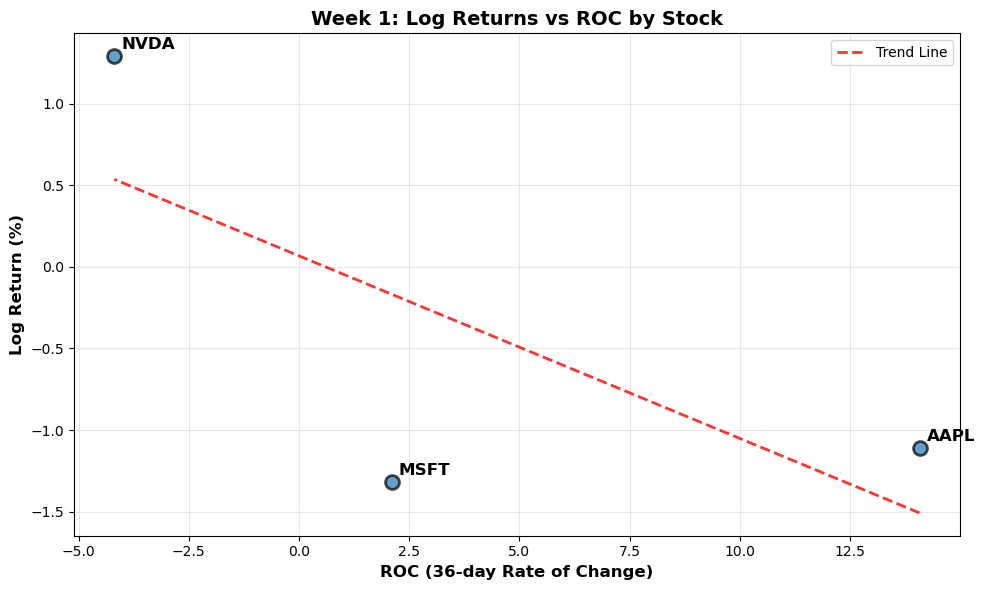

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract week 1 data
week_1_data = weekly_data.iloc[0]  # First row (week 1)

# Prepare data for scatter plot
plot_data = []
for ticker in stocks:
    log_return = week_1_data[(ticker, 'Log_Return_%')]
    roc = week_1_data[(ticker, 'ROC')]
    
    # Only include if both values are not NaN
    if pd.notna(log_return) and pd.notna(roc):
        plot_data.append({
            'Ticker': ticker,
            'Log_Return_%': log_return,
            'ROC': roc
        })

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['ROC'], plot_df['Log_Return_%'], 
           s=100, alpha=0.7, edgecolors='black', linewidth=2)

# Add labels for each point
for i, row in plot_df.iterrows():
    plt.annotate(row['Ticker'], 
                (row['ROC'], row['Log_Return_%']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=12, fontweight='bold')

plt.xlabel('ROC (36-day Rate of Change)', fontsize=12, fontweight='bold')
plt.ylabel('Log Return (%)', fontsize=12, fontweight='bold')
plt.title('Week 1: Log Returns vs ROC by Stock', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add a trend line if we have data
if len(plot_df) > 1:
    z = np.polyfit(plot_df['ROC'], plot_df['Log_Return_%'], 1)
    p = np.poly1d(z)
    plt.plot(plot_df['ROC'], p(plot_df['ROC']), 
             "r--", alpha=0.8, linewidth=2, label=f'Trend Line')
    plt.legend()

plt.tight_layout()
plt.show()

In [14]:
data = {
    'col1': [1, 2, 3, 4],
    'col2': [4, 5, 6, 7]
}

df = pd.DataFrame(data)
print(df)

def getsum(daFrame, n):
    return df.iloc[n].sum()

def getProduct(daFrame, n):
    return df.iloc[n].prod()

sumList = []
productList = []
for i in range(len(df)):
    sumList.append(
        getsum(df, i)
    )
    productList.append(
        getProduct(df, i)
    )

print(sumList)
print(productList)

df_2 = pd.DataFrame({
    'sum': sumList,
    'product': productList
})
print(df_2)

   col1  col2
0     1     4
1     2     5
2     3     6
3     4     7
[5, 7, 9, 11]
[4, 10, 18, 28]
   sum  product
0    5        4
1    7       10
2    9       18
3   11       28


In [15]:
def getRowCalculations(dataFrame, n):
    row = dataFrame.iloc[n]
    return row.sum(), row.prod()

# Single loop with tuple unpacking
calculations = [getRowCalculations(df, i) for i in range(len(df))]
sums, products = zip(*calculations)

df_2 = pd.DataFrame({
    'sum': sums,
    'product': products
})

print(calculations)

[(5, 4), (7, 10), (9, 18), (11, 28)]


In [16]:
data = {
    'col1': [1, 2, 3, 4],
    'col2': [4, 5, 6, 7]
}

df = pd.DataFrame(data)
print(df)

# Direct pandas operations - much faster
df_2 = pd.DataFrame({
    'sum': df.sum(axis=1),      # Sum each row
    'product': df.prod(axis=1)   # Product of each row
})
print(df_2)

   col1  col2
0     1     4
1     2     5
2     3     6
3     4     7
   sum  product
0    5        4
1    7       10
2    9       18
3   11       28
